# Thompson Sampling

In [1]:
options(repr.plot.width=12, repr.plot.height=8)

## Algorithm Steps

## **Step 1: Define Variables**
At each round $n$, we maintain the following statistics for each ad $i$:

- $S_i(n)$ - the number of **successes** (clicks) for ad $i$ up to round $n$.
- $F_i(n)$ - the number of **failures** (no clicks) for ad $i$ up to round $n$.

## **Step 2: Sample from the Posterior**
For each ad $i$, we **draw a random sample** from a **Beta distribution**:

$$
\theta_i(n) \sim \text{Beta}(S_i(n) + 1, F_i(n) + 1)
$$

where:
- $S_i(n) + 1$ represents the number of observed **successes** plus one pseudo-count (Bayesian prior).
- $F_i(n) + 1$ represents the number of observed **failures** plus one pseudo-count.

## **Step 3: Select the Best Ad**
We select the ad $i$ with the **highest sampled value** $\theta_i(n)$:

$$
i^* = \arg\max_i \theta_i(n)
$$

## **Step 4: Observe the Reward and Update**
After displaying the selected ad $i^*$, we observe the reward $y_{i^*}(n)$, which follows a Bernoulli distribution:

$$
y_{i^*}(n) \sim \mathcal{B}(\theta_{i^*})
$$

- If $y_{i^*}(n) = 1$ (success), then we update $S_{i^*}(n) = S_{i^*}(n) + 1$.
- If $y_{i^*}(n) = 0$ (failure), then we update $F_{i^*}(n) = F_{i^*}(n) + 1$.

## **Summary**
Thompson Sampling uses **Bayesian inference** to balance **exploration** (trying less explored ads) and **exploitation** (choosing the best-performing ad). Unlike **UCB**, which constructs confidence intervals, **Thompson Sampling directly samples from a probability distribution** and is often more efficient in practice.


## Goal

The goal of training the Thompson Sampling algorithm for selecting the best advertisement is to maximize the total number of clicks by balancing exploration and exploitation.

![](./pic/ads.png) 

## Libraries Loading

In [2]:
library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data Loading

In [3]:
data <- read_csv("../00_data/Ads_CTR_Optimisation.csv", show_col_types = FALSE)

head(data)

Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,0,0,0,1,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0


In [4]:
dim(data)

[1] 10000    10

In [5]:
glimpse(data)

Rows: 10,000
Columns: 10
$ `Ad 1`  <dbl> 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ `Ad 2`  <dbl> 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,…
$ `Ad 3`  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ `Ad 4`  <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ `Ad 5`  <dbl> 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,…
$ `Ad 6`  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ `Ad 7`  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ `Ad 8`  <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,…
$ `Ad 9`  <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,…
$ `Ad 10` <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


## Implementing Thompson Sampling

In [6]:
max_round <- nrow(data) # number of rounds
max_ads <- ncol(data)   # number of ads
selected_ads <- numeric(length = max_round) # index of selected ad during the round
# Step 1.
number_of_rewards_1 <- numeric(length = max_ads) # number of successes per ad
number_of_rewards_0 <- numeric(length = max_ads) # number of failures pre ad

round_rewards <- numeric(length = max_round) # reward per each round

for(n in 1:max_round){
    selected_ad_idx <- 1
    max_theta <- 0 # max theta (for Step 3.)
    for(i in 1:max_ads){
        # Step 2.
        random_theta = rbeta(n = 1, 
                             shape1 = number_of_rewards_1[i] + 1,
                             shape2 = number_of_rewards_0[i] + 1)
        # Step 3.
        if(random_theta > max_theta){
            max_theta <- random_theta
            selected_ad_idx <- i
        }
    }
    selected_ads[n] <- selected_ad_idx
    # Step 4.
    reward <- data[n, selected_ad_idx]
    if(reward == 1){
        number_of_rewards_1[selected_ad_idx] = number_of_rewards_1[selected_ad_idx] + 1
    } else{
        number_of_rewards_0[selected_ad_idx] = number_of_rewards_0[selected_ad_idx] + 1
    }
    round_rewards[n] <- reward
}

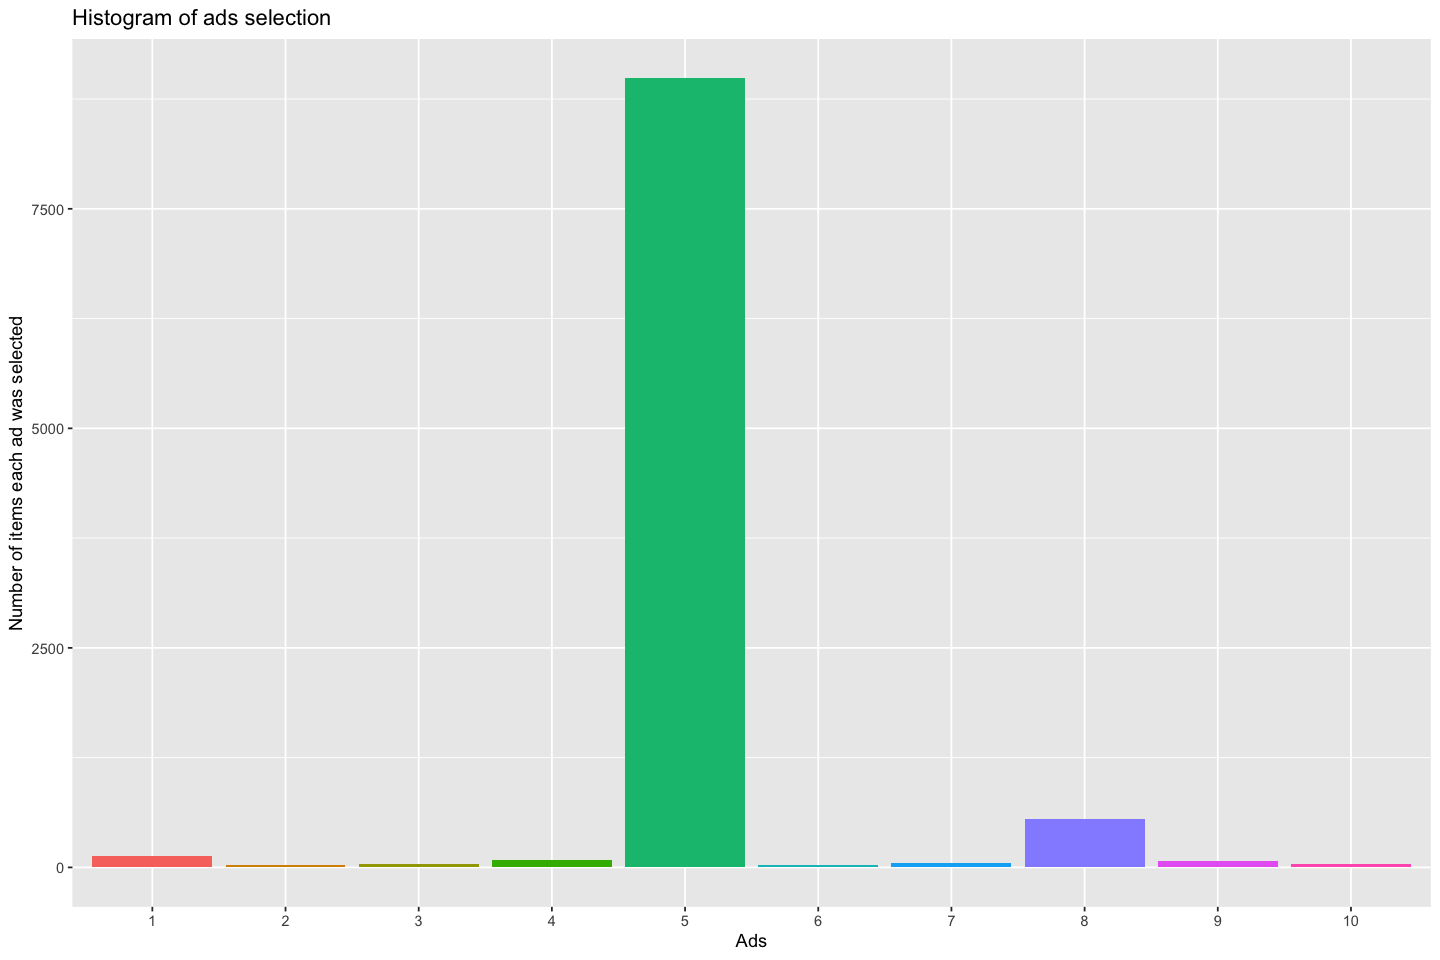

In [7]:
# plot histogram
ggplot(data.frame(ads = selected_ads)) +
    geom_bar(aes(x = factor(ads), fill = factor(ads))) +
    labs(title = "Histogram of ads selection",
         x = "Ads",
         y = "Number of items each ad was selected") +
    theme(legend.position = "None")

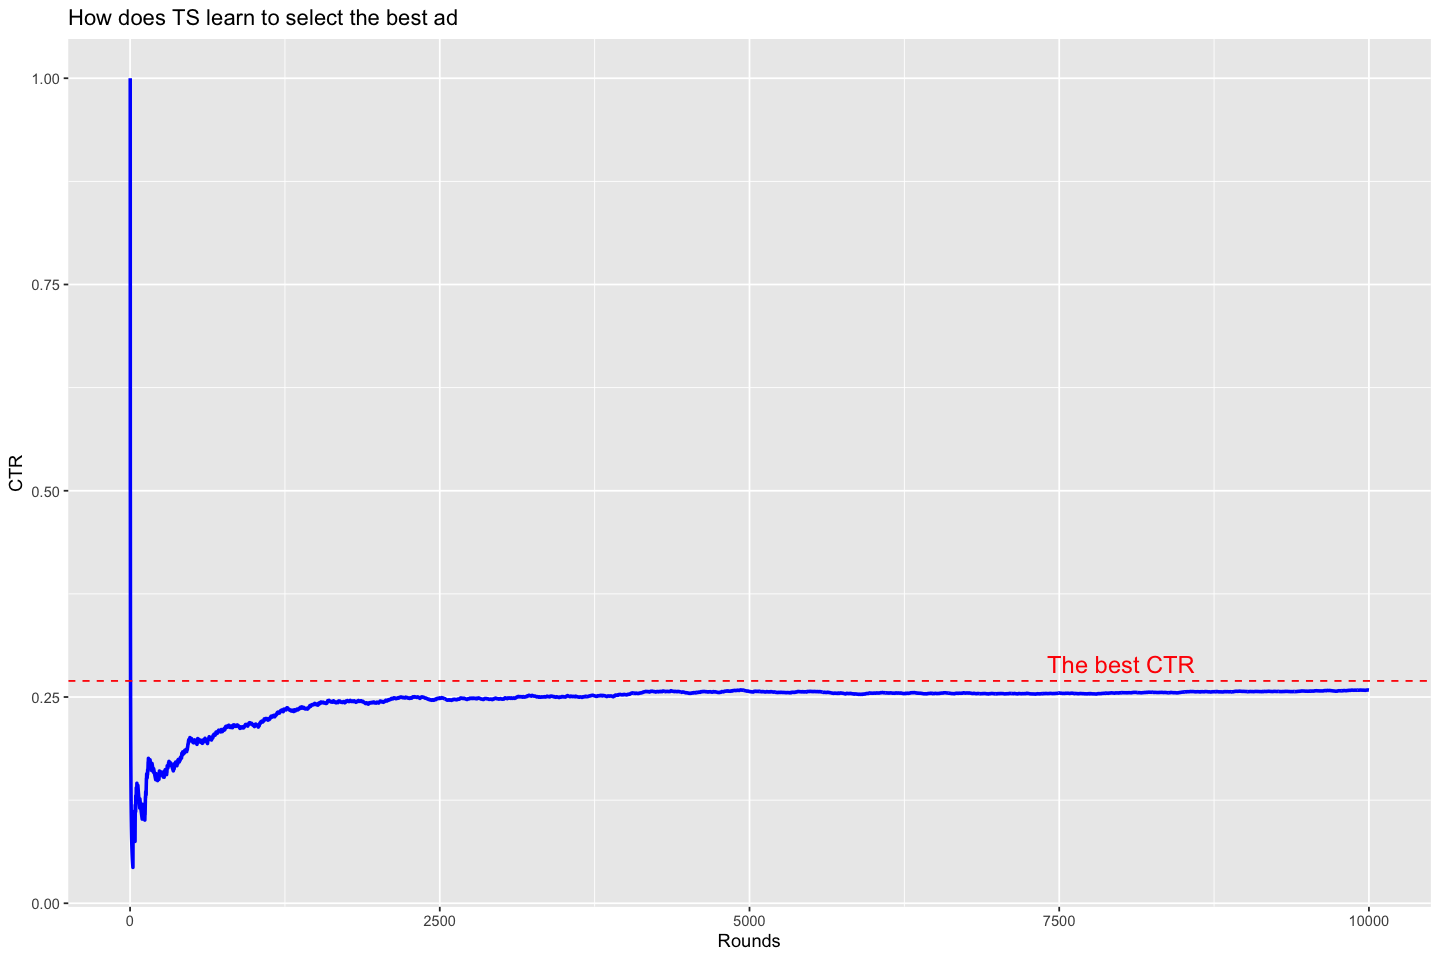

In [8]:
# plot the learning process 
best_ctr <- max(sapply(data, function(x) sum(x) / length(x)))
ggplot(data.frame(round = 1:max_round,
                        CTR = cumsum(round_rewards) / (1:max_round))) +
          geom_line(aes(x = round, y = CTR), color = "blue", linewidth=1) +
          geom_hline(yintercept = best_ctr, linetype = 2, color = "red") +
          annotate("text", x = max_round * 0.8, y = best_ctr + 0.02, label = "The best CTR", color = "red", size = 5) +
          labs(title = "How does TS learn to select the best ad",
             x = "Rounds",
             y = "CTR") +
          theme(legend.position = "None")